# Github Contributor Analysis

**"Active" Contributors and "Drifting" Contributors**

This notebook analyze data in the Augur DB. We would like to know how many users are "Actively" contributing to a project vs. those that are "Drifting" away from being an "Active" contributor.

## Imports/DBConnect

In [1]:
import psycopg2
import numpy as np
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = (15, 5)
import warnings
warnings.filterwarnings('ignore')

with open("../config_temp.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['augur']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[840]


## Motivations and Definitions

**Motivations**

The contributorship of a project will naturally be relatively fluid- contributors will gain and lose interest periodically, moving between their own personal priorities. Whether an individual contributor is engaged with the development of a project or not, given that said contributor is not a maintainer or an owner, is marginal. However, it is useful to know how many contributors can be considered "Active" by some definition, and comparatively how many could be defined at "Drifting." These values themselves don't lend much intuition in isolation but taken as parts of longitudinal time analysis, one can imagine that they might be useful to describe increases and decreases in project popularity and engagement.

**Definitions**

This notebook was motivated by some very interesting work done by the Linux Foundation in their dashboard for the projects that they maintain and we'll be borrowing their definitions of "Active" and "Drifting" in the hopes that a first-pass on this problem can be comparable to their results. 

"Active" - "Contributors performing code activity (Commits, PRs/Changesets/Issues) within the last 1 year are active code contributors."

"Drifting" - "(Those contributors who have) not perform(ed) any code activity in the last 6 months..."

## SQL Queries

### Issues

Below will give the most recent issue creation per user.

In [19]:
df_issues = pd.DataFrame()

repo_id = repo_set[0]

pr_query = salc.sql.text(f"""
            SELECT
                ca.cntrb_id,
                MAX(i.created_at) as recent_issue
            FROM
                issues i,
                contributors_aliases ca
            WHERE
                i.repo_id = \'{repo_id}\' AND
                ca.cntrb_alias_id = i.reporter_id or
                ca.cntrb_id = i.reporter_id
            GROUP BY
                ca.cntrb_id
            ORDER BY
                MAX(i.created_at) DESC
    """)

df_issues = pd.read_sql(pr_query, con=engine)

df_issues = df_issues.reset_index()
df_issues.drop("index", axis=1, inplace=True)

num_unique = len(pd.unique(df_issues.cntrb_id))
print(f"Num Distinct Issue Submitters: {num_unique}")
df_issues.head(10)

Num Distinct Issue Submitters: 802


,cntrb_id,recent_issue
0,279022,2021-10-21 12:11:30
1,341536,2021-10-21 10:33:08
2,277725,2021-10-21 10:20:12
3,279490,2021-10-21 09:05:14
4,277115,2021-10-21 08:56:41
5,277249,2021-10-21 07:23:02
6,279256,2021-10-21 06:19:22
7,277237,2021-10-21 02:03:39
8,277594,2021-10-21 00:39:41
9,279108,2021-10-20 21:13:23


### Commit Authors

Below will give the most recent git commit authorship per user.

In [20]:
df_commit_authors = pd.DataFrame()

repo_id = repo_set[0]

pr_query = salc.sql.text(f"""
            SELECT
                ca.cntrb_id,
                MAX(c.cmt_author_timestamp) as recent_authorship
            FROM
                commits c,
                contributors_aliases ca
            WHERE
                c.repo_id = \'{repo_id}\' AND
                c.cmt_author_email = ca.alias_email
            GROUP BY
                ca.cntrb_id
            ORDER BY
                MAX(c.cmt_author_timestamp) DESC
    """)

df_commit_authors = pd.read_sql(pr_query, con=engine)

df_commit_authors = df_commit_authors.reset_index()
df_commit_authors.drop("index", axis=1, inplace=True)

num_unique = len(pd.unique(df_commit_authors.cntrb_id))
print(f"Num Distinct Commit Authors: {num_unique}")

df_commit_authors.head(10)

Num Distinct Commit Authors: 54


,cntrb_id,recent_authorship
0,341790,2021-10-14 01:01:50+02:00
1,341806,2021-10-08 01:47:35+02:00
2,364119,2021-10-06 20:31:06+02:00
3,364114,2021-09-30 19:06:53+02:00
4,341795,2021-09-03 11:56:32+02:00
5,341808,2021-08-13 22:20:30+02:00
6,364127,2021-07-22 22:29:28+02:00
7,341807,2021-07-17 01:02:00+02:00
8,341815,2021-07-15 15:17:00+02:00
9,341817,2021-07-12 09:11:07+02:00


### Commit Committers

Below will give the most recent git commit committership per user.

In [21]:
df_commit_committers = pd.DataFrame()

repo_id = repo_set[0]

pr_query = salc.sql.text(f"""
            SELECT
                ca.cntrb_id,
                MAX(c.cmt_committer_timestamp) as recent_committership
            FROM
                commits c,
                contributors_aliases ca
            WHERE
                c.repo_id = \'{repo_id}\' AND
                c.cmt_committer_email = ca.alias_email
            GROUP BY
                ca.cntrb_id
            ORDER BY
                MAX(c.cmt_committer_timestamp) DESC
    """)

df_commit_committers = pd.read_sql(pr_query, con=engine)

df_commit_committers = df_commit_committers.reset_index()
df_commit_committers.drop("index", axis=1, inplace=True)

num_unique = len(pd.unique(df_commit_committers.cntrb_id))
print(f"Num Distinct Commit Committers: {num_unique}")

df_commit_committers.head(10)

Num Distinct Commit Committers: 46


,cntrb_id,recent_committership
0,364156,2021-10-14 01:01:50+02:00
1,341790,2021-10-14 01:00:49+02:00
2,341806,2021-10-08 01:47:35+02:00
3,364119,2021-10-06 20:31:06+02:00
4,364114,2021-09-30 19:06:53+02:00
5,364127,2021-07-22 22:19:29+02:00
6,341807,2021-07-17 01:02:31+02:00
7,341815,2021-07-15 15:17:00+02:00
8,341817,2021-07-12 09:11:07+02:00
9,341823,2021-06-07 16:52:20+02:00


### PR Submitters

Below will give the most recent PR Submission per user.

In [22]:
df_pr_submitters = pd.DataFrame()

repo_id = repo_set[0]

pr_query = salc.sql.text(f"""
            SELECT
                ca.cntrb_id,
                MAX(p.pr_created_at) as recent_pr_creatorship
            FROM
                pull_requests p,
                contributors_aliases ca
            WHERE
                p.repo_id = \'{repo_id}\' AND
                p.pr_augur_contributor_id = ca.cntrb_id
            GROUP BY
                ca.cntrb_id
            ORDER BY
                MAX(p.pr_created_at) DESC

    """)

df_pr_submitters = pd.read_sql(pr_query, con=engine)

df_pr_submitters = df_pr_submitters.reset_index()
df_pr_submitters.drop("index", axis=1, inplace=True)

num_unique = len(pd.unique(df_pr_submitters.cntrb_id))
print(f"Num Distinct PR Submitters: {num_unique}")


df_pr_submitters.head(10)

Num Distinct PR Submitters: 37


,cntrb_id,recent_pr_creatorship
0,341790,2021-10-13 23:01:23
1,341794,2021-09-13 12:02:12
2,341795,2021-09-03 10:01:04
3,341805,2021-08-19 13:21:27
4,341806,2021-08-18 16:23:42
5,341808,2021-08-13 20:19:02
6,341807,2021-07-16 23:05:10
7,341815,2021-07-15 13:18:22
8,341817,2021-07-12 07:16:21
9,341820,2021-06-24 20:21:12


### Query Aggregation

We have four relations. They describe the most recent user activities in Issues, Commits, and PR's for this project.
Now, we have to aggregate them to get the most recent activity of any kind per user.

We have to:

(1) Make sure that all of the activity timestamps are of a single comparable type. (DONE)

(2) Join the four relations on cntrb_id, allowing for NaN's where a user might not have a recent date for something
    (i.e. if a user only ever creates issues but never authors PR's, or if a user only ever creates PR's as responses
        to issues but never creates them themselves.) (DONE)
        
(3) Separate the aggregate relation into (i) those contributors who have contributed in some way in the last 6 months
    vs. (ii) those who have not. These population will be active vs. drifting contributors respectively. (DONE)

In [8]:
print("===================df_issues===================")
print(df_issues.dtypes)
print()

print("===================df_commit_authors===================")
# convert datetime.date object to np.datetime64 for comparison convenience
df_commit_authors.recent_authorship = df_commit_authors.recent_authorship.apply(lambda x: np.datetime64(x))
print(df_commit_authors.dtypes)
print()

print("===================df_commit_committers===================")
# convert datetime.date object to np.datetime64 for comparison convenience
df_commit_committers.recent_committership = df_commit_committers.recent_committership.apply(lambda x: np.datetime64(x))
print(df_commit_committers.dtypes)
print()

print("===================df_pr_submitters===================")
print(df_pr_submitters.dtypes)
print()

# perform the relevant joins. This could be more concise but it is how it is for the moment.
df_merged = df_issues.set_index("cntrb_id").join(df_pr_submitters.set_index("cntrb_id"))
df_merged = df_merged.join(df_commit_authors.set_index("cntrb_id"))
df_merged = df_merged.join(df_commit_committers.set_index("cntrb_id"))

# change all NaT to 0
df_merged = df_merged.apply(lambda x: 0 if x is pd.NaT else x)
# take the maximum value from each row and create a new column for it
df_merged["most_recent"] = df_merged.apply(np.max,  axis=1)
print("===================df_merged===================")
print(df_merged.dtypes)

df_recent = df_merged[ "most_recent"].reset_index()
df_recent.tail(10)

# df_merged_nonan = df_merged[~df_merged.isnull().any(axis=1)]
# df_merged_nonan.head(50)

===================df_issues===================
cntrb_id                 int64
recent_issue    datetime64[ns]
dtype: object

===================df_commit_authors===================
cntrb_id                      int64
recent_authorship    datetime64[ns]
dtype: object

===================df_commit_committers===================
cntrb_id                         int64
recent_committership    datetime64[ns]
dtype: object

===================df_pr_submitters===================
cntrb_id                          int64
recent_pr_creatorship    datetime64[ns]
dtype: object

===================df_merged===================
recent_issue             datetime64[ns]
recent_pr_creatorship    datetime64[ns]
recent_authorship        datetime64[ns]
recent_committership     datetime64[ns]
most_recent              datetime64[ns]
dtype: object


,cntrb_id,most_recent
792,278707,2012-10-11 22:06:44
793,277429,2012-09-25 02:01:20
794,278711,2012-09-18 14:39:41
795,279109,2012-09-06 21:39:02
796,279113,2012-08-27 15:24:53
797,279117,2012-07-18 13:31:35
798,277432,2012-04-12 03:10:20
799,279139,2012-02-23 19:20:18
800,278475,2011-11-17 18:42:31
801,277434,2011-10-05 20:12:09


**Separate on Contribution Date**

Now that we have the most recent contribution by all of the unique cntrb_id's, we just need to separate the populations into those who are currently 'active' vs. those who are 'drifting' which is arbitrarily selected based on a 6 month window.

In [9]:
# today, 6 month time difference, date six months ago
now = np.datetime64('now')
sixmos =  np.timedelta64(6, "M").astype('timedelta64[ns]')
sixmosago = now - sixmos

In [10]:
# df of "active contributors" vs df of "drifting contributors"
df_active = df_recent[ df_recent["most_recent"] >= sixmosago]

condition = df_recent["cntrb_id"].isin(df_active["cntrb_id"])
df_drifting = df_recent.drop(df_recent[condition].index)

Text(0, 0.5, 'Count')

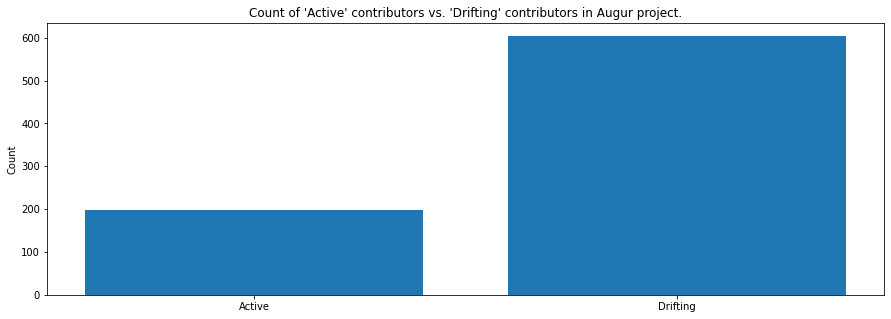

In [11]:
plt.bar(["Active", "Drifting"], [df_active.shape[0], df_drifting.shape[0]])
plt.title("Count of 'Active' contributors vs. 'Drifting' contributors in Augur project.")
plt.ylabel("Count")

## Longitudinal Analysis

We have shown how many contributors are currently 'active' vs. 'drifting'. Now we are interesting in looking at this over the existence of the project. (i.e. starting from the beginning of the project, in regular intervals, how many contributors are 'active' vs. 'drifting'?)

First step will be to get a list of dates that we can work with. We'll be going from the first day of the repo to the current day in 3 month time-bins.

In [12]:
now = np.datetime64('now')
start = np.datetime64("2017-01-01") + np.timedelta64(6, "M").astype('timedelta64[ns]') # need to start 6mos out from start
threemos =  np.timedelta64(3, "M").astype('timedelta64[ns]')

curr_time = start
time_range = [curr_time]
while(curr_time < now):
    curr_time += threemos
    if(curr_time > now):
        break
    time_range.append(curr_time)

The next step will be to get the count of 'active' and 'drifting' contributors for those contributions that were made before each of the binned dates.

### Convenient Time-bounded Interfaces

The following are functions that let us easily constrain the maximum date we can consider. From this we are able to get an 'Active' vs. 'Drifting' plot for the project from its inception through to now.

In [13]:
def dated_issues( date_lim ):
    
    # run the query to get all of the issues and their corresponding contributor.
    df_issues_dated = pd.DataFrame()

    repo_id = repo_set[0]

    pr_query = salc.sql.text(f"""
                SELECT
                    ca.cntrb_id,
                    i.created_at as recent_issue
                FROM
                    issues i,
                    contributors_aliases ca
                WHERE
                    i.repo_id = \'{repo_id}\' AND
                    ca.cntrb_alias_id = i.reporter_id or
                    ca.cntrb_id = i.reporter_id
        """)

    df_issues_dated = pd.read_sql(pr_query, con=engine)

    df_issues_dated = df_issues_dated.reset_index()
    df_issues_dated.drop("index", axis=1, inplace=True)
    
    # return only those issues that were made before the date threshold.
    df_lim = df_issues_dated[ df_issues_dated["recent_issue"] < date_lim ]
    return df_lim.groupby(["cntrb_id"], sort=False)["recent_issue"].max().reset_index()
    
df_test = dated_issues(time_range[-1])
df_test.head(5)

,cntrb_id,recent_issue
0,277128,2020-05-02 14:56:48
1,277110,2021-09-24 22:38:22
2,277130,2021-09-23 11:53:33
3,277132,2020-05-18 14:37:33
4,277125,2018-12-20 02:58:36


In [14]:
def dated_commit_authorship( date_lim ):
    df_commit_authors_dated = pd.DataFrame()

    repo_id = repo_set[0]

    pr_query = salc.sql.text(f"""
                SELECT
                    ca.cntrb_id,
                    c.cmt_author_timestamp as recent_authorship
                FROM
                    commits c,
                    contributors_aliases ca
                WHERE
                    c.repo_id = \'{repo_id}\' AND
                    c.cmt_author_email = ca.alias_email
        """)

    df_commit_authors_dated = pd.read_sql(pr_query, con=engine)

    df_commit_authors_dated = df_commit_authors_dated.reset_index()
    df_commit_authors_dated.drop("index", axis=1, inplace=True)
    
    df_commit_authors_dated.recent_authorship = df_commit_authors_dated.recent_authorship.apply(lambda x: np.datetime64(x))
    df_lim = df_commit_authors_dated[ df_commit_authors_dated["recent_authorship"] < date_lim ]
    return df_lim.groupby(["cntrb_id"], sort=False)["recent_authorship"].max().reset_index()
    
    
df_test = dated_commit_authorship(time_range[-1])
df_test.head(5)   

,cntrb_id,recent_authorship
0,341537,2020-09-18 12:29:41
1,341552,2020-03-28 20:25:51
2,299124,2017-03-07 21:38:34
3,341844,2020-12-29 05:22:27
4,364113,2020-07-13 17:49:08


In [15]:
def dated_commit_committership( date_lim ):
    df_commit_committers_dated = pd.DataFrame()

    repo_id = repo_set[0]

    pr_query = salc.sql.text(f"""
                SELECT
                    ca.cntrb_id,
                    c.cmt_committer_timestamp as recent_committership
                FROM
                    commits c,
                    contributors_aliases ca
                WHERE
                    c.repo_id = \'{repo_id}\' AND
                    c.cmt_committer_email = ca.alias_email
        """)

    df_commit_committers_dated = pd.read_sql(pr_query, con=engine)

    df_commit_committers_dated = df_commit_committers_dated.reset_index()
    df_commit_committers_dated.drop("index", axis=1, inplace=True)
    
    df_commit_committers_dated.recent_committership = df_commit_committers_dated.recent_committership.apply(lambda x: np.datetime64(x))
    
    df_lim = df_commit_committers_dated[ df_commit_committers_dated["recent_committership"] < date_lim ]
    return df_lim.groupby(["cntrb_id"], sort=False)["recent_committership"].max().reset_index()

df_test = dated_commit_committership(time_range[-1])
df_test.head(5)

,cntrb_id,recent_committership
0,341948,2020-05-05 21:32:17
1,299124,2017-03-07 21:38:34
2,364121,2019-11-15 20:03:41
3,341863,2019-12-19 19:10:03
4,341790,2021-09-30 18:55:02


In [16]:
def dated_pr_submitters( date_lim ):
    df_pr_submitters_dated = pd.DataFrame()

    repo_id = repo_set[0]

    pr_query = salc.sql.text(f"""
                SELECT
                    ca.cntrb_id,
                    p.pr_created_at as recent_pr_creatorship
                FROM
                    pull_requests p,
                    contributors_aliases ca
                WHERE
                    p.repo_id = \'{repo_id}\' AND
                    p.pr_augur_contributor_id = ca.cntrb_id
        """)

    df_pr_submitters_dated = pd.read_sql(pr_query, con=engine)

    df_pr_submitters_dated = df_pr_submitters_dated.reset_index()
    df_pr_submitters_dated.drop("index", axis=1, inplace=True)
    
    df_lim = df_pr_submitters_dated[ df_pr_submitters_dated["recent_pr_creatorship"] < date_lim ]
    return df_lim.groupby(["cntrb_id"], sort=False)["recent_pr_creatorship"].max().reset_index()

df_test = dated_pr_submitters(time_range[-1])
df_test.head(5)

,cntrb_id,recent_pr_creatorship
0,341790,2021-09-06 23:10:23
1,341947,2018-08-27 23:22:24
2,341950,2018-03-18 10:08:42
3,341804,2017-01-31 17:08:16
4,341958,2017-02-01 20:33:36


### Look at 'Active' vs. 'Drifting' from project's beginning onward.

In [17]:
def get_contributor_status_long(time_range_bins):
    
    counts = []
    sixmos =  np.timedelta64(6, "M").astype('timedelta64[ns]')
    its = len(time_range_bins)
    for idx, lim in enumerate(time_range_bins):
        print(f"It: {idx}/{its-1}")
        
        # get all of the time-limited df's
        df_issues = dated_issues( lim )
        df_cmt_auth = dated_commit_authorship( lim )
        df_cmt_cmt = dated_commit_committership( lim )
        df_pr_sub = dated_pr_submitters( lim )
        
        # join the df's
        df_merged = df_issues.set_index("cntrb_id").join(df_cmt_auth.set_index("cntrb_id"))
        df_merged = df_merged.join(df_cmt_cmt.set_index("cntrb_id"))
        df_merged = df_merged.join(df_pr_sub.set_index("cntrb_id"))

        # change all NaT to 0
        df_merged = df_merged.apply(lambda x: 0 if x is pd.NaT else x)
        # take the maximum value from each row and create a new column for it
        df_merged["most_recent"] = df_merged.apply(np.max,  axis=1)

        df_recent = df_merged["most_recent"].reset_index()
        
        # get those individuals who have authored something in the last 6 months from the date limit.
        sixmosago = lim - sixmos
        df_active = df_recent[ df_recent["most_recent"] >= sixmosago]

        condition = df_recent["cntrb_id"].isin(df_active["cntrb_id"])
        df_drifting = df_recent.drop(df_recent[condition].index)
        
        counts.append([df_active.shape[0], df_drifting.shape[0], lim])
        
    return counts
        
long_state_counts = get_contributor_status_long( time_range )

It: 0/17
It: 1/17
It: 2/17
It: 3/17
It: 4/17
It: 5/17
It: 6/17
It: 7/17
It: 8/17
It: 9/17
It: 10/17
It: 11/17
It: 12/17
It: 13/17
It: 14/17
It: 15/17
It: 16/17
It: 17/17


### Plot the Retention of Active Users over time.

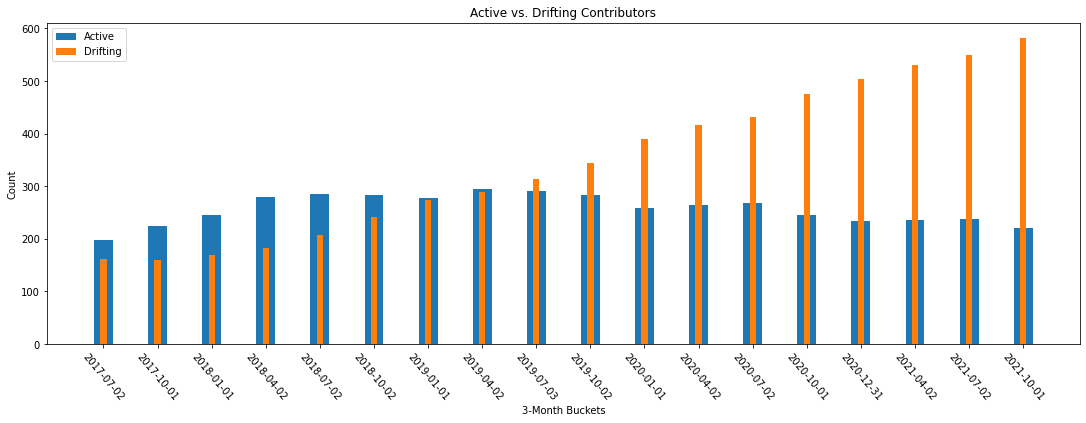

In [18]:
"""
    Reference:
    https://stackoverflow.com/questions/23293011/how-to-plot-a-superimposed-bar-chart-using-matplotlib-in-python
"""

def plot_counts( counts ):
    a = [x[0] for x in counts]
    b = [x[1] for x in counts]
    d = [np.datetime_as_string(x[2])[:10] for x in counts]
    
    ind = np.arange(len(counts))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    active = ax.bar(x=ind, height=a, width=0.35,align='center')
    drift = ax.bar(x=ind, height=b, width=0.35/3,  align='center')
    
    plt.tight_layout()
    
    plt.xticks(ind, d, rotation=310)
    
    plt.title("Active vs. Drifting Contributors")
    plt.ylabel("Count")
    plt.xlabel("3-Month Buckets")
    
    plt.legend([active, drift], ["Active", "Drifting"])
    
    plt.show()
    
plot_counts(long_state_counts)

## Conclusions

We can see that there is a fairly steady number of 'active' contributors to the project from its beginning through to the current state.
However, this is definitely a problem because we know that the project doesn't have 600-800 contributors total, 'active' or otherwise. This motivates a need to refine our approach to aggregating the total contributorship.

However, as proof of visualization, we can see what we might expect to see from a project: Over time, there are more individuals who have contributed something and then left than there are a total number of 'active' contributors. However, it is interesting that the total number of 'active' contributors hasn't grown over time. I think that this is due to counting issues, not a product of the project itself.

**UPDATE**

It looks like the number of issue submitters causes a dramatic over-estimation of the total number of contributors. If we take that into account and only include those individuals who have made content-related submissions (Commits / PR's) we see the following:

In [23]:
def get_contributor_status_long_no_issues(time_range_bins):
    
    counts = []
    sixmos =  np.timedelta64(6, "M").astype('timedelta64[ns]')
    its = len(time_range_bins)
    for idx, lim in enumerate(time_range_bins):
        print(f"It: {idx}/{its-1}")
        
        # get all of the time-limited df's
        #df_issues = dated_issues( lim )
        df_cmt_auth = dated_commit_authorship( lim )
        df_cmt_cmt = dated_commit_committership( lim )
        df_pr_sub = dated_pr_submitters( lim )
        
        # join the df's
        df_merged = df_cmt_auth.set_index("cntrb_id").join(df_cmt_cmt.set_index("cntrb_id"))
        df_merged = df_merged.join(df_pr_sub.set_index("cntrb_id"))

        # change all NaT to 0
        df_merged = df_merged.apply(lambda x: 0 if x is pd.NaT else x)
        # take the maximum value from each row and create a new column for it
        df_merged["most_recent"] = df_merged.apply(np.max,  axis=1)

        df_recent = df_merged["most_recent"].reset_index()
        
        # get those individuals who have authored something in the last 6 months from the date limit.
        sixmosago = lim - sixmos
        df_active = df_recent[ df_recent["most_recent"] >= sixmosago]

        condition = df_recent["cntrb_id"].isin(df_active["cntrb_id"])
        df_drifting = df_recent.drop(df_recent[condition].index)
        
        counts.append([df_active.shape[0], df_drifting.shape[0], lim])
        
    return counts
        
long_state_counts_no_issues = get_contributor_status_long_no_issues( time_range )

It: 0/17
It: 1/17
It: 2/17
It: 3/17
It: 4/17
It: 5/17
It: 6/17
It: 7/17
It: 8/17
It: 9/17
It: 10/17
It: 11/17
It: 12/17
It: 13/17
It: 14/17
It: 15/17
It: 16/17
It: 17/17


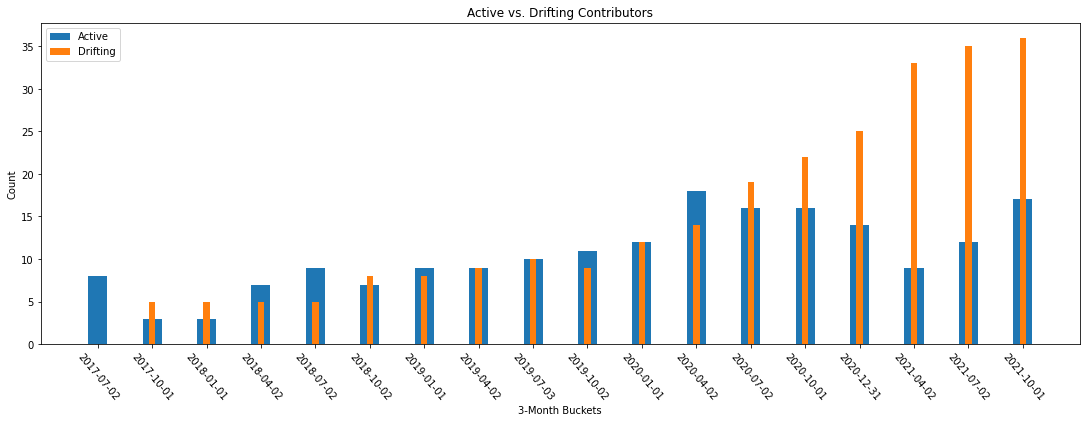

In [24]:
plot_counts( long_state_counts_no_issues )

### Extended Analysis

This looks like a far more reasonable plot of the 'Active' vs. 'Drifting' problem, including the fact that, at the beginning of the project, there are no 'drifting' contributors since the project started 6 months earlier.